In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
import featuretools as ft
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [39]:
# load data
dataframe_org = pd.read_csv('train.csv', delimiter='|')
dataframe_org.drop(dataframe_org.loc[dataframe_org['trustLevel']>=3].index, inplace=True)

dataframe = dataframe_org.copy()


########### manual feature generation ##########

# totalScanned:
dataframe['totalScanned'] = dataframe['scannedLineItemsPerSecond'] * dataframe['totalScanTimeInSeconds']
# avgValuePerScan:
dataframe['avgTimePerScan'] = 1/ dataframe['scannedLineItemsPerSecond']
dataframe['avgValuePerScan'] = dataframe['avgTimePerScan'] * dataframe['valuePerSecond']
# manual feature generation - "totalScanned" ratios
# withoutRegisPerPosition
dataframe['withoutRegisPerPosition'] = dataframe['scansWithoutRegistration'] / dataframe['totalScanned']
# ratio of scansWithoutRegis in totalScan
# equivalent to lineItemVoidsPerPosition
# Might indicate how new or ambivalent a customer is. Expected to be higher for low "trustLevel"
# quantiModPerPosition
dataframe['quantiModPerPosition'] = dataframe['quantityModifications'] / dataframe['totalScanned']
# ratio of quanityMods in totalScan
# manual feature generation - "grandTotal" ratios
# lineItemVoidsPerTotal
dataframe['lineItemVoidsPerTotal'] = dataframe['lineItemVoids'] / dataframe['grandTotal']
# withoutRegisPerTotal
dataframe['withoutRegisPerTotal'] = dataframe['scansWithoutRegistration'] / dataframe['grandTotal']
# quantiModPerTotal
dataframe['quantiModPerTotal'] = dataframe['quantityModifications'] / dataframe['grandTotal']
# manual feature generation - "totalScanTimeInSeconds" ratios
# lineItemVoidsPerTime
dataframe['lineItemVoidsPerTime'] = dataframe['lineItemVoids'] / dataframe['totalScanTimeInSeconds']
# withoutRegisPerTime
dataframe['withoutRegisPerTime'] = dataframe['scansWithoutRegistration'] / dataframe['totalScanTimeInSeconds']
# quantiModPerTime
dataframe['quantiModPerTime'] = dataframe['quantityModifications'] / dataframe['totalScanTimeInSeconds']

########### end manual feature generation ###########


X = dataframe.drop('fraud',axis=1)
y = dataframe['fraud']
es = ft.EntitySet(id = 'customers')
es = es.entity_from_dataframe(entity_id='customers',dataframe=X,
                              variable_types = {'trustLevel': ft.variable_types.Categorical},index='id',make_index=True)



In [26]:
dataframe = dataframe[['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'totalScanned', 'avgTimePerScan',
       'avgValuePerScan', 'withoutRegisPerPosition', 'quantiModPerPosition',
       'lineItemVoidsPerTotal', 'withoutRegisPerTotal', 'quantiModPerTotal',
       'lineItemVoidsPerTime', 'withoutRegisPerTime', 'quantiModPerTime', 'fraud']]

In [27]:
cv = StratifiedKFold(n_splits=10, random_state=42)
def profit_scorer(y, y_pred):
    profit_matrix = {(0,0): 0, (0,1): -5, (1,0): -25, (1,1): 5}
    return sum(profit_matrix[(pred, actual)] for pred, actual in zip(y_pred, y))
profit_scoring = make_scorer(profit_scorer, greater_is_better=True)

In [28]:
#Baseline model of original data w/out pre-processing
X_base_org = dataframe_org.drop('fraud',axis=1)
y_base_org = dataframe_org['fraud']
print('Baseline models of original data w/out pre-processing and default parameters: \n')
print('XGB: {}'.format(sum(cross_validate(XGBClassifier(), X_base_org, y=y_base_org, cv=cv, scoring=profit_scoring)['test_score'])))
print('LR: {}'.format(sum(cross_validate(LogisticRegression(), X_base_org, y=y_base_org, cv=cv, scoring=profit_scoring)['test_score'])))
print('GNB: {}'.format(sum(cross_validate(GaussianNB(), X_base_org, y=y_base_org, cv=cv, scoring=profit_scoring)['test_score'])))
print('KNN: {}'.format(sum(cross_validate(KNeighborsClassifier(), X_base_org, y=y_base_org, cv=cv, scoring=profit_scoring)['test_score'])))
print('RF: {}'.format(sum(cross_validate(RandomForestClassifier(), X_base_org, y=y_base_org, cv=cv, scoring=profit_scoring)['test_score'])))
print('MLP: {}'.format(sum(cross_validate(MLPClassifier(), X_base_org, y=y_base_org, cv=cv, scoring=profit_scoring)['test_score'])))
print('SVC: {}'.format(sum(cross_validate(SVC(), X_base_org, y=y_base_org, cv=cv, scoring=profit_scoring)['test_score'])))
print('SGD: {}'.format(sum(cross_validate(SGDClassifier(), X_base_org, y=y_base_org, cv=cv, scoring=profit_scoring)['test_score'])))

Baseline models of original data w/out pre-processing and default parameters: 

XGB: -20
LR: -335
GNB: -6230
KNN: -995
RF: -215
MLP: -1810
SVC: -520
SGD: -1785


In [29]:
#Baseline models of data w/ manual feature generated
X_base = dataframe.drop('fraud',axis=1)
y_base = dataframe['fraud']
print('Baseline models of data w/ manual features generated: \n')
print('XGB: {}'.format(sum(cross_validate(XGBClassifier(), X_base, y=y_base, cv=cv, scoring=profit_scoring)['test_score'])))
print('LR: {}'.format(sum(cross_validate(LogisticRegression(), X_base, y=y_base, cv=cv, scoring=profit_scoring)['test_score'])))
print('GNB: {}'.format(sum(cross_validate(GaussianNB(), X_base, y=y_base, cv=cv, scoring=profit_scoring)['test_score'])))
print('KNN: {}'.format(sum(cross_validate(KNeighborsClassifier(), X_base, y=y_base, cv=cv, scoring=profit_scoring)['test_score'])))
print('RF: {}'.format(sum(cross_validate(RandomForestClassifier(), X_base, y=y_base, cv=cv, scoring=profit_scoring)['test_score'])))
print('MLP: {}'.format(sum(cross_validate(MLPClassifier(), X_base, y=y_base, cv=cv, scoring=profit_scoring)['test_score'])))
print('SVC: {}'.format(sum(cross_validate(SVC(), X_base, y=y_base, cv=cv, scoring=profit_scoring)['test_score'])))
print('SGD: {}'.format(sum(cross_validate(SGDClassifier(), X_base, y=y_base, cv=cv, scoring=profit_scoring)['test_score'])))

Baseline models of data w/ manual features generated: 

XGB: 160
LR: 210
GNB: -4840
KNN: -970
RF: -115
MLP: -1130
SVC: -520
SGD: -3110


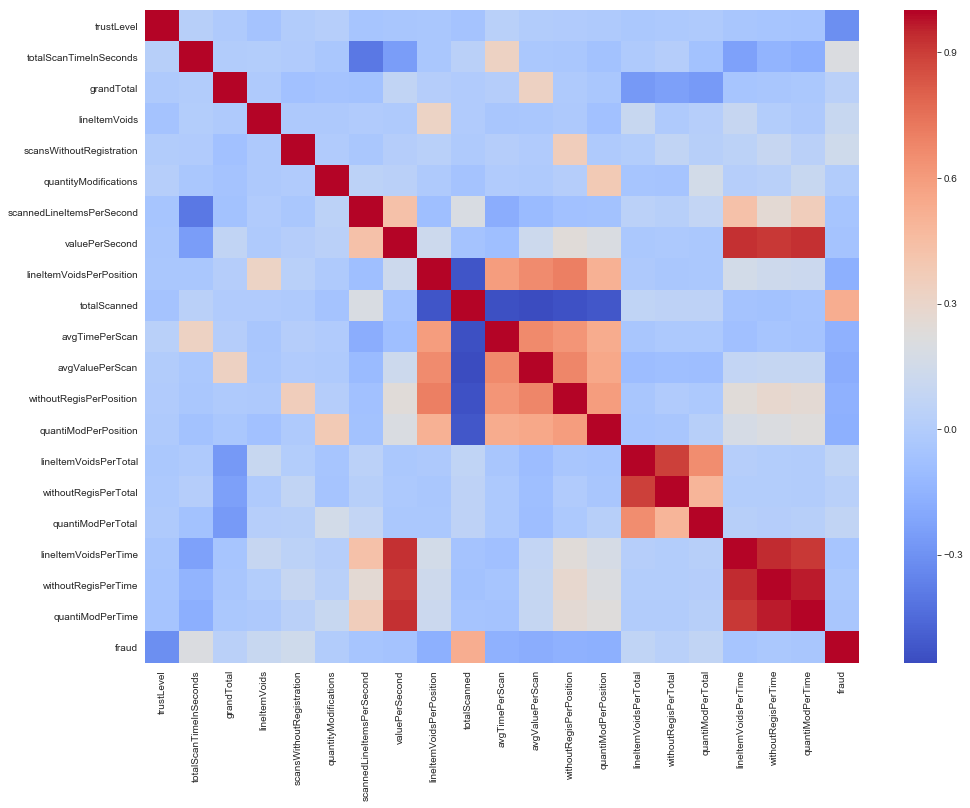

In [30]:
plt.figure(figsize=(16,12))
sns.heatmap(dataframe.corr(), cmap='coolwarm')

In [31]:
# SelectKBest with chi squared (chi^2) statistical test for non-negative features
from sklearn.feature_selection import chi2
# feature extraction
test = SelectKBest(score_func=chi2, k=6)
fit = test.fit(X_base, y_base)
# summarize scores
np.set_printoptions(precision=2)
print(fit.scores_)
print(X_base.columns)
features = fit.transform(X_base)
# summarize selected features
print(features[0:5,:])

[1.09e+01 9.27e+03 1.60e+01 1.53e+01 2.75e+01 5.83e-03 6.48e-01 8.57e+00
 3.86e+01 9.25e+02 5.67e+03 4.08e+02 3.57e+01 2.36e+01 2.47e+01 5.90e+00
 9.18e+00 9.92e-01 1.01e+00 6.98e-01]
Index(['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'totalScanned', 'avgTimePerScan',
       'avgValuePerScan', 'withoutRegisPerPosition', 'quantiModPerPosition',
       'lineItemVoidsPerTotal', 'withoutRegisPerTotal', 'quantiModPerTotal',
       'lineItemVoidsPerTime', 'withoutRegisPerTime', 'quantiModPerTime'],
      dtype='object')
[[7.70e+02 4.23e-01 2.60e+01 2.96e+01 4.27e-01 1.92e-01]
 [1.54e+03 0.00e+00 1.00e+01 1.55e+02 2.28e+00 8.00e-01]
 [7.25e+02 3.70e-01 2.70e+01 2.69e+01 1.52e+00 7.41e-02]
 [8.70e+02 5.00e-01 6.00e+00 1.45e+02 5.41e+00 1.67e-01]
 [1.25e+02 2.08e-01 2.40e+01 5.21e+00 1.06e+00 2.50e-01]]


6 Features selected by SelectKBest based on chi2 (the ones that have the highest score in the first array of the output)<br>'totalScanTimeInSeconds', 'avgTimePerScan', 'totalScanned', 'avgValuePerScan', 'trustLevel', 'lineItemVoidsPerPosition'

In [32]:
#testing the 6 best performing features w/ all others excluded 
X_kselect = dataframe[['totalScanTimeInSeconds', 'avgTimePerScan', 'totalScanned', 
                       'avgValuePerScan', 'trustLevel', 'lineItemVoidsPerPosition']]
y_kselect = dataframe['fraud']
print('Different classifiers tested w/ only the 6 best performing features selected by KSelect: \n')
print('XGB: {}'.format(sum(cross_validate(XGBClassifier(), X_kselect, y=y_kselect, cv=cv, scoring=profit_scoring)['test_score'])))
print('LR: {}'.format(sum(cross_validate(LogisticRegression(), X_kselect, y=y_kselect, cv=cv, scoring=profit_scoring)['test_score'])))
print('GNB: {}'.format(sum(cross_validate(GaussianNB(), X_kselect, y=y_kselect, cv=cv, scoring=profit_scoring)['test_score'])))
print('KNN: {}'.format(sum(cross_validate(KNeighborsClassifier(), X_kselect, y=y_kselect, cv=cv, scoring=profit_scoring)['test_score'])))
print('RF: {}'.format(sum(cross_validate(RandomForestClassifier(), X_kselect, y=y_kselect, cv=cv, scoring=profit_scoring)['test_score'])))
print('MLP: {}'.format(sum(cross_validate(MLPClassifier(), X_kselect, y=y_kselect, cv=cv, scoring=profit_scoring)['test_score'])))
print('SVC: {}'.format(sum(cross_validate(SVC(), X_kselect, y=y_kselect, cv=cv, scoring=profit_scoring)['test_score'])))
print('SGD: {}'.format(sum(cross_validate(SGDClassifier(), X_kselect, y=y_kselect, cv=cv, scoring=profit_scoring)['test_score'])))

Different classifiers tested w/ only the 6 best performing features selected by KSelect: 

XGB: -10
LR: -55
GNB: -3565
KNN: -830
RF: -205
MLP: -755
SVC: -545
SGD: -5275


In [33]:
print('XGB with SelectKBest k=4: \n')
# create feature union
features = []
features.append(('select_best', SelectKBest(k=9)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_pca_kBest = Pipeline(estimators)
# evaluate pipeline

print('W/out pre-processing: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base_org, y=y_base_org, 
                                                           cv=cv, scoring=profit_scoring)['test_score'])))
print('W/ manual feature generated: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base, y=y_base
                                                          , cv=cv, scoring=profit_scoring)['test_score'])))
print('---------')
print('XGB with SelectKBest k=5: \n')
# create feature union
features = []
features.append(('select_best', SelectKBest(k=9)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_pca_kBest = Pipeline(estimators)
# evaluate pipeline

print('W/out pre-processing: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base_org, y=y_base_org, 
                                                           cv=cv, scoring=profit_scoring)['test_score'])))
print('W/ manual feature generated: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base, y=y_base
                                                          , cv=cv, scoring=profit_scoring)['test_score'])))
print('---------')
print('XGB with SelectKBest k=6: \n')
# create feature union
features = []
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_pca_kBest = Pipeline(estimators)
# evaluate pipeline

print('W/out pre-processing: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base_org, y=y_base_org, 
                                                           cv=cv, scoring=profit_scoring)['test_score'])))
print('W/ manual feature generated: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base, y=y_base
                                                          , cv=cv, scoring=profit_scoring)['test_score'])))

print('---------')
print('XGB with SelectKBest k=7: \n')
# create feature union
features = []
features.append(('select_best', SelectKBest(k=7)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_pca_kBest = Pipeline(estimators)
# evaluate pipeline

print('W/out pre-processing: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base_org, y=y_base_org, 
                                                           cv=cv, scoring=profit_scoring)['test_score'])))
print('W/ manual feature generated: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base, y=y_base
                                                          , cv=cv, scoring=profit_scoring)['test_score'])))

print('---------')
print('XGB with SelectKBest k=8: \n')
# create feature union
features = []
features.append(('select_best', SelectKBest(k=8)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_pca_kBest = Pipeline(estimators)
# evaluate pipeline

print('W/out pre-processing: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base_org, y=y_base_org, 
                                                           cv=cv, scoring=profit_scoring)['test_score'])))
print('W/ manual feature generated: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base, y=y_base
                                                          , cv=cv, scoring=profit_scoring)['test_score'])))
print('---------')
print('XGB with SelectKBest k=9: \n')
# create feature union
features = []
features.append(('select_best', SelectKBest(k=9)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_pca_kBest = Pipeline(estimators)
# evaluate pipeline

print('W/out pre-processing: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base_org, y=y_base_org, 
                                                           cv=cv, scoring=profit_scoring)['test_score'])))
print('W/ manual feature generated: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base, y=y_base
                                                          , cv=cv, scoring=profit_scoring)['test_score'])))
print('---------')
print('XGB with SelectKBest k=10: \n')
# create feature union
features = []
features.append(('select_best', SelectKBest(k=9)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_pca_kBest = Pipeline(estimators)
# evaluate pipeline

print('W/out pre-processing: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base_org, y=y_base_org, 
                                                           cv=cv, scoring=profit_scoring)['test_score'])))
print('W/ manual feature generated: {}'.format(sum(cross_validate(xgb_pca_kBest, X_base, y=y_base
                                                          , cv=cv, scoring=profit_scoring)['test_score'])))

XGB with SelectKBest k=4: 

W/out pre-processing: -20
W/ manual feature generated: 200
---------
XGB with SelectKBest k=5: 

W/out pre-processing: -20
W/ manual feature generated: 200
---------
XGB with SelectKBest k=6: 

W/out pre-processing: -320
W/ manual feature generated: -35
---------
XGB with SelectKBest k=7: 

W/out pre-processing: -210
W/ manual feature generated: 30
---------
XGB with SelectKBest k=8: 

W/out pre-processing: -125
W/ manual feature generated: 165
---------
XGB with SelectKBest k=9: 

W/out pre-processing: -20
W/ manual feature generated: 200
---------
XGB with SelectKBest k=10: 

W/out pre-processing: -20
W/ manual feature generated: 200


In [34]:
# create feature union
features = []
features.append(('pca', PCA(n_components=3)))
features.append(('select_best', SelectKBest(k=4)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_pca_kBest = Pipeline(estimators)
# evaluate pipeline

print(sum(cross_validate(xgb_pca_kBest, X_base_org, y=y_base_org, cv=cv, scoring=profit_scoring)['test_score']))
print(sum(cross_validate(xgb_pca_kBest, X_base, y=y_base, cv=cv, scoring=profit_scoring)['test_score']))

-405
-145


In [35]:
# Testing PCA, automatic feature generation w/ featuretools (previously manual generated features incorporated), 
# and SelectKBest

# create feature union
features = []
features.append(('pca', PCA(n_components=3)))
features.append(('ft', ft.wrappers.DFSTransformer(entityset = es, target_entity = 'customers', 
                                 agg_primitives = ['skew','trend','median', 'mean', 'max', 'std'],
                                 trans_primitives = ['subtract', 'percentile'])))
features.append(('select_best', SelectKBest(k=4)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_af = Pipeline(estimators)

print('XGB w/ PCA & featuretools & SelectKBest on data w/ additional manual features generated: {}'.format(sum(cross_validate(xgb_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])))

XGB w/ PCA & featuretools & SelectKBest on data w/ additional manual features generated: 100


Output: XGB w/ PCA & featuretools & SelectKBest on data w/ additional manual features generated: 100

In [36]:
# Testing PCA, automatic feature generation w/ featuretools (previously manual generated features incorporated), 
# and SelectKBest
# create feature union
features = []
features.append(('pca', PCA(n_components=3)))
features.append(('ft', ft.wrappers.DFSTransformer(entityset = es, target_entity = 'customers')))
features.append(('select_best', SelectKBest(k=4)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_af = Pipeline(estimators)

print('XGB w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: {}'
      .format(sum(cross_validate(xgb_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])))

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('LR', LogisticRegression()))
lr_af = Pipeline(estimators)

print('LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: {}'
      .format(sum(cross_validate(lr_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])))

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('RF', RandomForestClassifier()))
rf_af = Pipeline(estimators)

print('RF w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: {}'
      .format(sum(cross_validate(rf_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])))

XGB w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 100
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 305
RF w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: -30


Output: <br>
XGB w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 100<br>
LR w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: 305<br>
RF w/ PCA & featuretools (no primitives selected) & SelectKBest on data w/ additional manual features generated: -30<br>

In [37]:
# Testing automatic feature generation w/ featuretools
# create feature union
features = []
features.append(('ft', ft.wrappers.DFSTransformer(entityset = es, target_entity = 'customers')))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', XGBClassifier()))
xgb_af = Pipeline(estimators)

print('XGB w/ featuretools (no primitives selected) on data w/ additional manual generated features: {}'
      .format(sum(cross_validate(xgb_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])))

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('LR', LogisticRegression()))
lr_af = Pipeline(estimators)

print('LR w/ featuretools (no primitives selected) on data w/ additional manual generated features: {}'
      .format(sum(cross_validate(lr_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])))

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('RF', RandomForestClassifier()))
rf_af = Pipeline(estimators)

print('RF w/ featuretools (no primitives selected) on data w/ additional manual generated features: {}'
      .format(sum(cross_validate(rf_af, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])))

XGB w/ featuretools (no primitives selected) on data w/ additional manual generated features: 160
LR w/ featuretools (no primitives selected) on data w/ additional manual generated features: 235
RF w/ featuretools (no primitives selected) on data w/ additional manual generated features: 40


Output:<br>
XGB w/ featuretools (no primitives selected) on data w/ additional manual generated features: 160<br>
LR w/ featuretools (no primitives selected) on data w/ additional manual generated features: 235<br>
RF w/ featuretools (no primitives selected) on data w/ additional manual generated features: 40<br>

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_base, y_base)
print(X_base.columns)
print(model.feature_importances_)

Index(['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'totalScanned', 'avgTimePerScan',
       'avgValuePerScan', 'withoutRegisPerPosition', 'quantiModPerPosition',
       'lineItemVoidsPerTotal', 'withoutRegisPerTotal', 'quantiModPerTotal',
       'lineItemVoidsPerTime', 'withoutRegisPerTime', 'quantiModPerTime'],
      dtype='object')
[0.13 0.06 0.01 0.03 0.03 0.02 0.04 0.02 0.04 0.32 0.06 0.03 0.05 0.02
 0.02 0.02 0.02 0.02 0.03 0.01]


'trustLevel','totalScanned','totalScanTimeInSeconds','avgTimePerScan' have the highest feature importance with ExtraTreesClassifier

### The data w/ the manual features generated leads to the best performance for all tests except for Logistic Regression w/ PCA & featuretools (no primitives selected) & SelectKBest (k=4) on data w/ additional manual generated features incorporated